# Running Raven with Canopex data

The Canadian model parameter experiment (CANOPEX) database includes meteorological and hydrometric data as well as watershed boundaries for 698 basins. It is inspired by the US MOPEX project data and methods.

Metadata about watersheds can be found here: http://canopex.etsmtl.net/ for CANOPEX version 1. The THREDDS server stores CANOPEX version 2, which has many more watersheds but no accompanying public metadata. The database will later be updated with [HYSETS](https://osf.io/rpc3w/), the latest version of this hydrological database.

In this notebook, we show how to access CANOPEX data from the Ouranos THREDDS server through OPEnDAP streaming and run Raven with it. Meta data about the watersheds is stored in the `ravenpy/data/regionalization` folder.

In the following, we're using information from the `Station metadata` spreadsheet.

In [1]:
import datetime as dt
import json
import os
from pathlib import Path

import matplotlib.pyplot as plt
import netCDF4 as nc
import pandas as pd
import xarray as xr

import ravenpy

# DATA MAIN SOURCE - DAP link to CANOPEX dataset
CANOPEX_DAP = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/ets/Watersheds_5797_cfcompliant.nc"

In [2]:
# Open Canopex dataset using DAP link
ds = xr.open_dataset(CANOPEX_DAP)
display(ds)

<xarray.Dataset>
Dimensions:        (time: 22280, watershed: 5797)
Coordinates:
  * time           (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2010-12-31
  * watershed      (watershed) |S64 b'St. John River at Ninemile Bridge, Main...
Data variables:
    drainage_area  (watershed) float64 ...
    pr             (watershed, time) float64 ...
    tasmax         (watershed, time) float64 ...
    tasmin         (watershed, time) float64 ...
    discharge      (watershed, time) float64 ...
Attributes: (12/15)
    title:          Hydrometeorological data for lumped hydrological modellin...
    institute_id:   ETS
    contact:        Richard Arsenault: richard.arsenault@etsmtl.ca
    date_created:   2020-08-01
    source:         Hydrometric data from USGS National Water Information Ser...
    featureType:    timeSeries
    ...             ...
    activity:       PAVICS_Hydro
    Conventions:    CF-1.6, ACDD-1.3
    summary:        Hydrometeorological database for the PAVICS-Hydro platfor...
    institution:    ETS (École de technologie supérieure)
    DODS.strlen:    72
    DODS.dimName:   string72

In this notebook, we run Raven on the Whitemouth river, identified by its watershed name `WHITEMOUTH RIVER NEAR WHITEMOUTH`. The first step is find the index for the Whitemouth data in the CANOPEX data.

In [3]:
watersheds = pd.Series(ds.watershed)
name = b"WHITEMOUTH RIVER NEAR WHITEMOUTH"
i = watersheds[watersheds == name].index.values[0]
watersheds[i]

b'WHITEMOUTH RIVER NEAR WHITEMOUTH'

We can then retrieve metadata for this watershed from the database packaged with RavenPy.

In [4]:
fn = (
    Path(ravenpy.__file__).parent
    / "data"
    / "regionalisation"
    / "gauged_catchment_properties.csv"
)
meta = pd.read_csv(fn)
meta.loc[[i]]

,Unnamed: 0,ID,StationID,area,latitude,longitude,gravelius,perimeter,RunSuccessShape,elevation,...,RunSuccessTerrain,forest,grass,wetland,water,urban,shrubs,crops,snowIce,RunSuccessLandUse
5600,5600,5601.0,05PH003,3650.476385,49.511197,-95.721854,1.908497,408762.630635,1.0,330.589206,...,1.0,0.475752,0.029961,0.361967,0.023168,0.007692,0.06375,0.03771,0.0,1.0


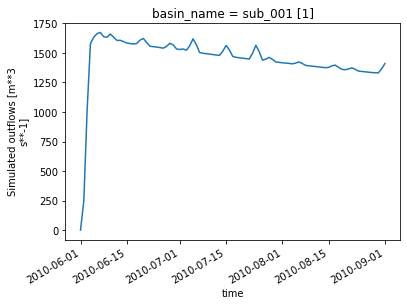

In [5]:
import warnings

from ravenpy.models import GR4JCN, RavenWarning

model = GR4JCN()

# Setup some parameters to run the models.
config = dict(
    start_date=dt.datetime(2010, 6, 1),
    end_date=dt.datetime(2010, 9, 1),
    meteo_idx=i,
    run_name="Test_run",
    rain_snow_fraction="RAINSNOW_DINGMAN",
    tasmax={"offset": -273.15},
    tasmin={"offset": -273.15},
    pr={"scale": 86400.0},
    hrus=[model.LandHRU(**meta[["area", "latitude", "longitude", "elevation"]].loc[i])],
)

# The model parameters.
params = [108.02, 2.8693, 25.352, 1.3696, 1.2483, 0.30679]

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RavenWarning)
    model(ts=CANOPEX_DAP, params=params, **config)

model.q_sim.plot();